In [2]:
import os
import mido
import pretty_midi
import numpy as np
from math import floor
import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [3]:
p_dataset = "/media/nova/Datasets/sageev-midi"
old_dataset_name = "20240621-nested"
new_dataset_name = "20250110"
p_old_dataset = os.path.join(p_dataset, old_dataset_name)
p_new_dataset = os.path.join(p_dataset, new_dataset_name)

In [4]:
def num_beats(midi: mido.MidiFile, bpm: int = 60) -> int:
    file_len_s = sum(msg.time for msg in midi)
    total_beats = file_len_s * bpm / 60

    return floor(total_beats)

In [5]:
def add_tempo_to_file(in_path: str, out_path: str, midi_file: str) -> bool:
    pf_midi = os.path.join(in_path, midi_file)

    # load midi file
    midi = mido.MidiFile(pf_midi)

    # extract timing information
    bpm = int(os.path.basename(midi_file).split("-")[1])
    tempo = mido.bpm2tempo(bpm)
    n_beats = num_beats(midi, bpm)
    beat_times_s = [
        mido.second2tick(60 / bpm, midi.ticks_per_beat, tempo)
        for _ in range(0, n_beats)
    ]

    # create tick track
    last_beat = 0
    tick_track = mido.MidiTrack()
    tick_track.append(mido.MetaMessage("track_name", name="tick", time=last_beat))
    for i, beat_time in enumerate(beat_times_s):
        beat_msg = mido.MetaMessage(
            "text",
            text=f"beat {i}",
            time=beat_time,
        )
        tick_track.append(beat_msg)
    midi.tracks.append(tick_track)

    # place new segment in proper subdir
    dirs = in_path.split("/")
    subdataset = dirs[-2]
    track = dirs[-1]
    pf_new_midi = os.path.join(out_path, subdataset, track, midi_file)
    os.makedirs(os.path.join(out_path, subdataset, track), exist_ok=True)
    # midi.print_tracks()
    midi.type = 1  # to allow saving with multiple tracks (some files generated by Live are type 0)
    midi.save(filename=pf_new_midi)
    print(f"\tsaved to {pf_new_midi}", end="\r")
    return os.path.isfile(pf_new_midi)

In [6]:
def show_beats(midi_path: str):
    # load file
    midi_mido = mido.MidiFile(midi_path)
    midi_pm = pretty_midi.PrettyMIDI(midi_path)
    # midi_mido.print_tracks()

    # make piano roll and beat arrays
    piano_roll = midi_pm.get_piano_roll() / 128.0
    beats = np.zeros_like(piano_roll)
    # print(f"pr has shape {piano_roll.shape} min={piano_roll.min()} max={piano_roll.max()}")

    # calculate pixel-tick conversion ratio
    pr_width = piano_roll.shape[1]
    bpm = int(os.path.basename(midi_path).split("-")[1])
    num_ticks = mido.second2tick(
        midi_pm.get_end_time(), midi_mido.ticks_per_beat, mido.bpm2tempo(bpm)
    )
    ticks_per_pixel = pr_width / num_ticks
    # print(f"num_ticks is {num_ticks} so there are {ticks_per_pixel} tpp")

    # place tick lines in beat array
    for track in midi_mido.tracks:
        first_msg = track[0]
        if first_msg.is_meta and first_msg.type == "track_name":
            if first_msg.name != "tick":
                # print(f"skipping track '{first_msg.name}'")
                continue

            current_tick = 0
            for msg in track:
                current_tick += msg.time
                tick_pixel = int(current_tick * ticks_per_pixel)
                # print(f"current tick = {current_tick} -> pixel {tick_pixel}")
                if 0 <= tick_pixel < pr_width:
                    beats[:, tick_pixel] = 1.0
                else:
                    print(f"\tbeat out of PR range {tick_pixel}")

    # stack images
    blue = np.zeros_like(beats)
    image = np.stack([piano_roll, beats, blue], axis=2)

    # display resulting image
    plt.figure(figsize=(12, 6))
    plt.title(f"{midi_path}")
    plt.imshow(image, aspect="auto", origin="lower")
    plt.axis("off")
    plt.show()

In [7]:
add_tempo_to_file(
    "/home/finlay/disklavier/notebooks/files",
    "files/out",
    # "20231220-080-01_0047-0053.mid",
    "20231220-080-06.mid",
)

True

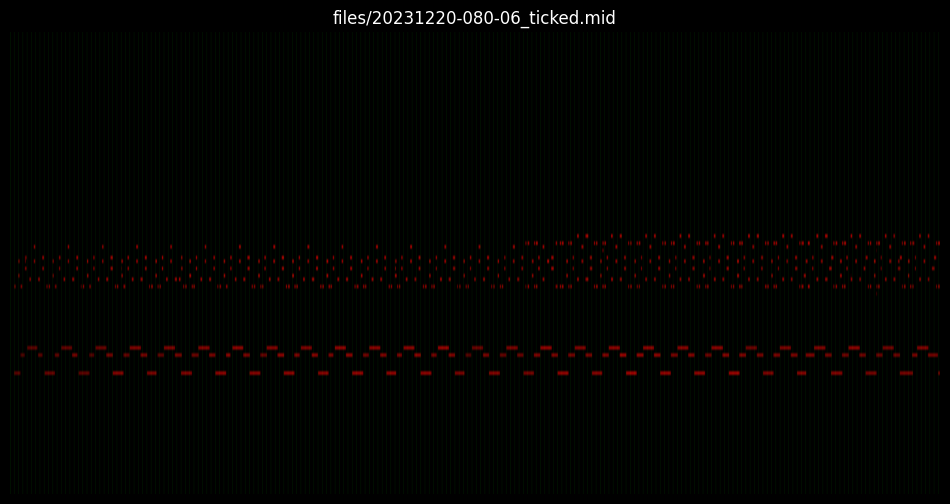

In [8]:
# show_beats("files/20231220-080-01_0047-0053-ticked.mid")
show_beats("files/20231220-080-06_ticked.mid")

In [9]:
n_files = 0
for folder, _, files in os.walk(p_old_dataset):
    # print(f"scanning '{folder}' ({len(files)} files found)")
    for file in files:
        if file.endswith(".mid") or file.endswith(".midi"):
            res = add_tempo_to_file(folder, p_new_dataset, file)
            if res:
                n_files += 1
            else:
                print(f"failed to write file '{folder}/{file}'")
print("DONE")

OSError: [Errno 28] No space left on device

In [8]:
import random

n_files = 10
all_files = []
for folder, _, files in os.walk(p_new_dataset):
    # print(f"scanning '{folder}' ({len(files)} files found)")
    for file in files:
        if file.endswith(".mid") or file.endswith(".midi"):
            all_files.append(os.path.join(folder, file))

random_files = random.sample(all_files, n_files)
random_files

['/media/nova/Datasets/sageev-midi/20250110/augmented/20231227-080-03/20231227-080-03_0239-0245_t09s03.mid',
 '/media/nova/Datasets/sageev-midi/20250110/augmented/20231220-080-01/20231220-080-01_0347-0353_t11s07.mid',
 '/media/nova/Datasets/sageev-midi/20250110/augmented/20240511-068-01/20240511-068-01_0155-0162_t02s02.mid',
 '/media/nova/Datasets/sageev-midi/20250110/augmented/20240126-050-03/20240126-050-03_0038-0047_t10s02.mid',
 '/media/nova/Datasets/sageev-midi/20250110/augmented/20240502-064-02/20240502-064-02_0044-0052_t01s00.mid',
 '/media/nova/Datasets/sageev-midi/20250110/augmented/20240312-080-06/20240312-080-06_0233-0239_t01s00.mid',
 '/media/nova/Datasets/sageev-midi/20250110/augmented/20231220-080-02/20231220-080-02_0311-0317_t09s07.mid',
 '/media/nova/Datasets/sageev-midi/20250110/augmented/20231220-080-01/20231220-080-01_0299-0305_t10s00.mid',
 '/media/nova/Datasets/sageev-midi/20250110/augmented/20240227-076-05/20240227-076-05_0536-0543_t04s07.mid',
 '/media/nova/Datas

In [ ]:
for file in random_files:
    show_beats(file)

NameError: name 'random_files' is not defined

In [48]:
# import os
# import shutil


# def organize_files_by_prefix(source_dir: str, destination_dir: str) -> None:
#     # ensure the destination directory exists
#     os.makedirs(destination_dir, exist_ok=True)

#     # iterate through files in the source directory
#     for filename in os.listdir(source_dir):
#         if not filename.endswith(".mid"):
#             continue  # skip non-.mid files

#         # extract the prefix (part before the underscore)
#         prefix = filename.split("_")[0]

#         # create a subdirectory for the prefix
#         prefix_dir = os.path.join(destination_dir, prefix)
#         os.makedirs(prefix_dir, exist_ok=True)

#         # copy the file to the appropriate subdirectory
#         source_file = os.path.join(source_dir, filename)
#         destination_file = os.path.join(prefix_dir, filename)
#         shutil.copy2(source_file, destination_file)


# # example usage
# organize_files_by_prefix(
#     "/media/nova/Datasets/sageev-midi/20240621/unsegmented",
#     "/media/nova/Datasets/sageev-midi/20240621-nested/unsegmented",
# )